In [262]:
!pip install torch torchvision
!pip install -U finance-datareader


Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.6)


In [0]:
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

In [0]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class TestDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=10)
        self.end = datetime.date.today()
        print(self.start)
        print(self.end)
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(6)
        print(self.data)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        #data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [0]:

#trainloader = torch.cat(trainloader).view(len(trainloader), batch_size, -1)
def train(model, trainStock, optimizer, loss_fn,batch_size,device):
    trainloader = DataLoader(trainStock, batch_size, shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(device)
        y_true = y[:, :, 3].float().to(device)

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [0]:
def validate(model, valStock, loss_fn,batch_size,device):
    valloader = DataLoader(valStock, batch_size, shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(device)
            y_true = y[:, :, 3].float().to(device)
            model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc


In [0]:
def test(model, testStock, loss_fn,batch_size,device):
    testloader = DataLoader(testStock, batch_size, shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    test_result = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(device)
            y_true = y[:, :, 3].float().to(device)
            model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_result.append([y_pred,y_true])
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc, test_result

In [272]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
xframe = 5
yframe = xframe

In [274]:
stock = StockDataset('028050',xframe,yframe,(2000,1,1), (2012,1,1))
valstock = StockDataset('028050',xframe,yframe,(2012,1,1), (2016,1,1))
teststock = StockDataset('028050',xframe,yframe,(2016,1,1), (2019,2,1))

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [275]:
batch_size = 100
input_dim = 6
hidden_dim = 50
output_dim = yframe
num_layers = 2
epoch = 10

model = LSTM(input_dim,hidden_dim,output_dim,num_layers,batch_size)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

'''
for i in range(5):
    model, tl = train(model,stock,optimizer,loss_fn,batch_size,device)
    vl = validate(model,valstock,loss_fn,batch_size,device)
    print(tl,vl)
ta = test(model,teststock,loss_fn,batch_size,device)
print(tl,vl,ta)
'''

'\nfor i in range(5):\n    model, tl = train(model,stock,optimizer,loss_fn,batch_size,device)\n    vl = validate(model,valstock,loss_fn,batch_size,device)\n    print(tl,vl)\nta = test(model,teststock,loss_fn,batch_size,device)\nprint(tl,vl,ta)\n'

In [276]:
#학습
for e in range(epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, stock ,optimizer, loss_fn, batch_size,device)
        val_loss, val_acc = validate(model, valstock, loss_fn, batch_size,device)
        te = time.time()
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(e, train_acc, val_acc, train_loss, val_loss, te-ts))
        
test_acc,test_result = test(model, teststock, loss_fn, batch_size, device ) 

Epoch 0, Acc(train/val): 156.11/153.55, Loss(train/val) 0.89967/0.85710. Took 27.83 sec
Epoch 1, Acc(train/val): 153.13/150.52, Loss(train/val) 0.85768/0.81419. Took 27.48 sec
Epoch 2, Acc(train/val): 150.02/147.14, Loss(train/val) 0.81086/0.76379. Took 27.27 sec
Epoch 3, Acc(train/val): 146.27/142.67, Loss(train/val) 0.75378/0.69534. Took 27.27 sec
Epoch 4, Acc(train/val): 139.53/132.00, Loss(train/val) 0.65658/0.56265. Took 27.49 sec
Epoch 5, Acc(train/val): 119.28/98.05, Loss(train/val) 0.46143/0.30298. Took 27.49 sec
Epoch 6, Acc(train/val): 73.91/44.33, Loss(train/val) 0.20290/0.10358. Took 27.46 sec
Epoch 7, Acc(train/val): 25.57/9.09, Loss(train/val) 0.06983/0.03771. Took 27.30 sec
Epoch 8, Acc(train/val): 8.50/6.33, Loss(train/val) 0.02716/0.01485. Took 27.34 sec
Epoch 9, Acc(train/val): 7.63/6.07, Loss(train/val) 0.01195/0.00671. Took 27.49 sec


In [277]:
print(test_acc)

7.106848852975028


In [278]:
testinput = StockDataset('068270',5,5,(2019,1,1),(2020,5,13))
testloader = DataLoader(testinput, batch_size, shuffle=False, drop_last=True)


Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [0]:

yp = []
yt = []

for i, (X,y) in enumerate(testloader):

    model.eval()
    X = X.transpose(0, 1).float().to(device)
    y_true = y[:, :, 3].float().to(device)
    model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

    y_pred = model(X)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = np.exp(y_pred.cpu().detach().numpy())
    y_true = np.exp(y_true.cpu().detach().numpy())
    yp.append(y_pred)
    yt.append(y_true)

In [285]:
pred = []
real = []
for i in range(len(yp)):
    for j in range(len(yp[i])):
        pred.append(yp[i][j])
        real.append(yt[i][j])

print(len(pred),len(real))

1500 1500


In [281]:
'''from google.colab import drive
drive.mount('/content/gdrive')
modelPath = '/content/gdrive/My Drive/LSTM_batch_1_model.pt'
torch.save(model.state_dict(), modelPath)'''

"from google.colab import drive\ndrive.mount('/content/gdrive')\nmodelPath = '/content/gdrive/My Drive/LSTM_batch_1_model.pt'\ntorch.save(model.state_dict(), modelPath)"

Text(0.5, 1.0, 'pred vs real')

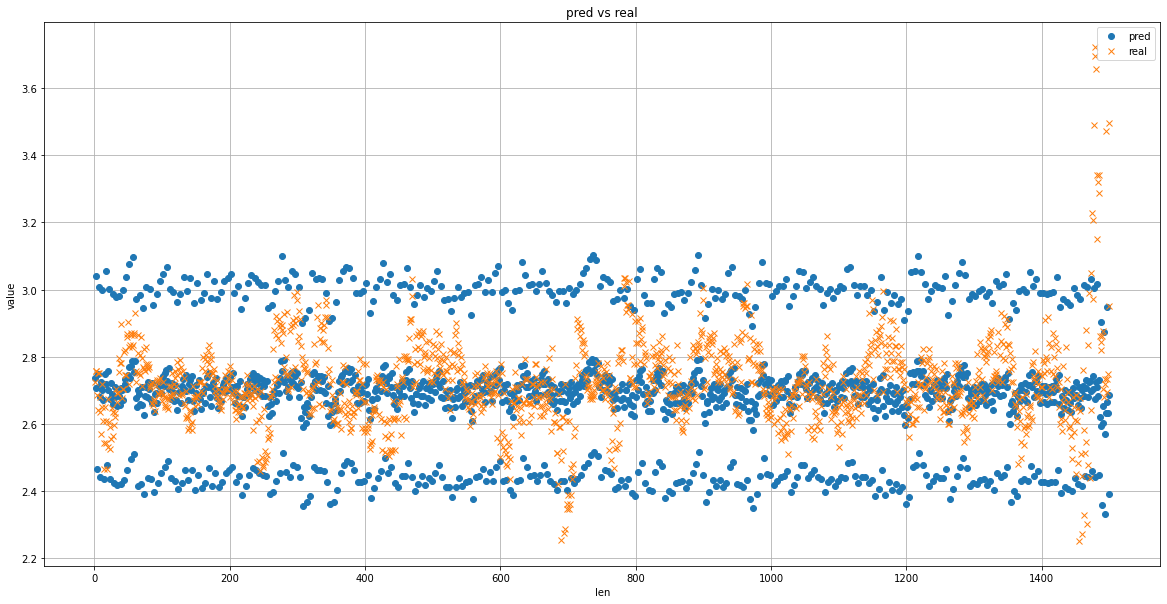

In [283]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(pred)+1)]

# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, pred, 'o', label='pred')
ax.plot(xl, real, 'x',label='real')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')